File used for experimenting with differeent techique and methods etc.

This file exists so that the code and model in Bayesian.ipynb stays consistent and is not altered, as that file will conatin the final model.

In [477]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from scipy.io import arff
import pgmpy
from pgmpy.estimators import HillClimbSearch, MmhcEstimator
from pgmpy.estimators import K2Score, BicScore, BDeuScore, BDsScore
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
import networkx as nx
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score
from pgmpy.inference import VariableElimination
from  pgmpy.inference.EliminationOrder import WeightedMinFill
from pgmpy.readwrite import BIFWriter

Data using downloaded files

Description of Attributes


X1	net profit / total assets\
X2	total liabilities / total assets\
X3	working capital / total assets\
X4	current assets / short-term liabilities\
X5	[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365\
X6	retained earnings / total assets\
X7	EBIT / total assets\
X8	book value of equity / total liabilities\
X9	sales / total assets\
X10	equity / total assets\
X11	(gross profit + extraordinary items + financial expenses) / total assets\
X12	gross profit / short-term liabilities\
X13	(gross profit + depreciation) / sales\
X14	(gross profit + interest) / total assets\
X15	(total liabilities * 365) / (gross profit + depreciation)\
X16	(gross profit + depreciation) / total liabilities\
X17	total assets / total liabilities\
X18	gross profit / total assets\
X19	gross profit / sales\
X20	(inventory * 365) / sales\
X21	sales (n) / sales (n-1)\
X22	profit on operating activities / total assets\
X23	net profit / sales\
X24	gross profit (in 3 years) / total assets\
X25	(equity - share capital) / total assets\
X26	(net profit + depreciation) / total liabilities\
X27	profit on operating activities / financial expenses\
X28	working capital / fixed assets\
X29	logarithm of total assets\
X30	(total liabilities - cash) / sales\
X31	(gross profit + interest) / sales\
X32	(current liabilities * 365) / cost of products sold\
X33	operating expenses / short-term liabilities\
X34	operating expenses / total liabilities\
X35	profit on sales / total assets\
X36	total sales / total assets\
X37	(current assets - inventories) / long-term liabilities\
X38	constant capital / total assets\
X39	profit on sales / sales\
X40	(current assets - inventory - receivables) / short-term liabilities\
X41	total liabilities / ((profit on operating activities + depreciation) * (12/365))\
X42	profit on operating activities / sales\
X43	rotation receivables + inventory turnover in days\
X44	(receivables * 365) / sales\
X45	net profit / inventory\
X46	(current assets - inventory) / short-term liabilities\
X47	(inventory * 365) / cost of products sold\
X48	EBITDA (profit on operating activities - depreciation) / total assets\
X49	EBITDA (profit on operating activities - depreciation) / sales\
X50	current assets / total liabilities\
X51	short-term liabilities / total assets\
X52	(short-term liabilities * 365) / cost of products sold)\
X53	equity / fixed assets\
X54	constant capital / fixed assets\
X55	working capital\
X56	(sales - cost of products sold) / sales\
X57	(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)\
X58	total costs /total sales\
X59	long-term liabilities / equity\
X60	sales / inventory\
X61	sales / receivables\
X62	(short-term liabilities *365) / sales\
X63	sales / short-term liabilities\
X64	sales / fixed assets\

In [478]:
X: pd.DataFrame
y: pd.DataFrame

arff_file_year_5 = arff.loadarff('PolishBankruptcy/5year.arff')

df = pd.DataFrame(arff_file_year_5[0])
for i in range(len(df)):
    if df.loc[i, 'class'] == b'0':
        df.loc[i, 'class'] = 0
    else:
        df.loc[i, 'class'] = 1
        
        
        
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, cols]

lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

df.loc[:, cols] = df_sub.where(lim, np.nan)
data = df.dropna()
data
#df

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.088238,0.55472,0.011340,1.02050,-66.520,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.25970,0
4,0.048179,0.55041,0.107650,1.24370,-22.959,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.36220,0
6,0.099486,0.59991,0.374890,1.65290,19.036,0.210840,0.123950,0.66690,1.0972,0.40009,...,0.088581,0.248660,0.91142,0.064344,5.4655,2.4784,130.020,2.8072,31.64500,0
7,0.078518,0.20546,0.103930,2.79390,77.784,0.365150,0.093388,3.86720,1.2322,0.79454,...,0.188420,0.098822,0.81158,0.185660,11.3790,3.1692,53.575,6.8129,0.47096,0
8,0.125040,0.35440,0.314190,2.71270,17.942,0.305750,0.158430,1.82170,1.2362,0.64560,...,0.191090,0.193680,0.80891,0.264790,4.7737,5.7479,59.841,6.0995,2.22740,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,0.016964,0.75503,0.081574,1.12680,-197.070,0.002708,0.016964,0.32445,0.8879,0.24497,...,0.202530,0.069249,0.96847,0.028093,8.9614,4.8148,264.490,1.3800,3.22850,1
5874,0.118540,0.51946,0.376420,1.96150,-80.058,0.000000,0.118540,0.92506,1.1781,0.48054,...,0.126960,0.246670,0.88039,0.259280,1.9625,7.1645,121.300,3.0090,5.08030,1
5892,0.112350,1.73990,-0.514250,0.43445,-82.297,-0.322010,0.112350,-0.42524,3.4144,-0.73987,...,-0.020766,-0.151850,0.96072,-1.122600,12.9690,32.4040,97.205,3.7549,5.64380,1
5893,-0.089739,1.33000,-0.314680,0.67454,-124.530,-1.260700,-0.089739,-0.24799,2.2327,-0.32981,...,0.220300,0.272090,0.79435,-0.428730,4.9425,15.4680,158.060,2.3092,6.41950,1


Standardizing Data

In [479]:
scaler = preprocessing.StandardScaler() 
data_scaled = scaler.fit_transform(data)
data_scaled_transposed = data_scaled.transpose()

attribute_names = [
    "X1",
    "X2",
    "X3",
    "X4",
    "X5",
    "X6",
    "X7",
    "X8",
    "X9",
    "X10",
    "X11",
    "X12",
    "X13",
    "X14",
    "X15",
    "X16",
    "X17",
    "X18",
    "X19",
    "X20",
    "X21",
    "X22",
    "X23",
    "X24",
    "X25",
    "X26",
    "X27",
    "X28",
    "X29",
    "X30",
    "X31",
    "X32",
    "X33",
    "X34",
    "X35",
    "X36",
    "X37",
    "X38",
    "X39",
    "X40",
    "X41",
    "X42",
    "X43",
    "X44",
    "X45",
    "X46",
    "X47",
    "X48",
    "X49",
    "X50",
    "X51",
    "X52",
    "X53",
    "X54",
    "X55",
    "X56",
    "X57",
    "X58",
    "X59",
    "X60",
    "X61",
    "X62",
    "X63",
    "X64",
    "class"
]

attribute_dict = {}

for i in range(len(data_scaled_transposed)):
    attribute_dict[attribute_names[i]] = data_scaled_transposed[i]

standardisedData = pd.DataFrame(attribute_dict)
standardisedData

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,0.321090,0.068564,-0.640252,-0.502941,-0.073726,0.960361,0.383209,-0.439017,-0.389134,-0.399677,...,0.040615,0.128727,-0.094596,-0.256968,-0.060838,-0.418844,0.486308,-0.642489,-0.057109,-0.186575
1,-0.016352,0.054603,-0.231350,-0.387324,-0.024759,-0.126527,-0.009768,-0.328340,0.230622,0.023217,...,1.126398,0.005791,-1.139657,-0.167846,-0.056795,-0.499671,0.057034,-0.455199,-0.056019,-0.186575
2,0.415839,0.214941,0.903268,-0.175360,0.022448,0.543452,0.496383,-0.397679,-0.375923,-0.138768,...,0.092546,0.109169,-0.148266,-0.216532,-0.063402,-0.704058,0.335773,-0.588745,0.244774,-0.186575
3,0.239213,-1.062743,-0.247144,0.415673,0.088486,1.033797,0.257184,1.082462,-0.179936,1.152035,...,0.772426,-0.000300,-0.850554,-0.137818,-0.055004,-0.616720,-0.567499,0.271015,-0.086768,-0.186575
4,0.631097,-0.580304,0.645555,0.373612,0.021218,0.845044,0.766247,0.136417,-0.174129,0.664642,...,0.790609,0.069002,-0.869335,-0.086475,-0.064385,-0.290694,-0.493460,0.117895,-0.068088,-0.186575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,-0.279295,0.717399,-0.342060,-0.447878,-0.220477,-0.117922,-0.340962,-0.556062,-0.679776,-0.646384,...,0.868512,-0.021906,0.253031,-0.240054,-0.058437,-0.408666,1.924666,-0.895070,-0.057441,5.359783
2939,0.576343,-0.045649,0.909764,-0.015507,-0.088944,-0.126527,0.454041,-0.278279,-0.258476,0.124498,...,0.353898,0.107715,-0.366535,-0.090050,-0.068377,-0.111593,0.232737,-0.545431,-0.037747,5.359783
2940,0.524201,3.907546,-2.871743,-0.806512,-0.091460,-1.149766,0.405594,-0.902794,2.988093,-3.869185,...,-0.652081,-0.183437,0.198517,-0.986671,-0.052746,3.079447,-0.051968,-0.385336,-0.031754,5.359783
2941,-1.178122,2.579816,-2.024431,-0.682147,-0.138934,-4.132607,-1.176092,-0.820816,1.272549,-2.527300,...,0.989522,0.126287,-0.971752,-0.536459,-0.064145,0.938222,0.667092,-0.695632,-0.023504,5.359783


Normalize Data

In [480]:
data
normalizer = preprocessing.Normalizer()
data_normalised = normalizer.fit_transform(data)
data_normalised_transposed = data_normalised.transpose()

normalised_dict = {}

for i in range(len(data_normalised_transposed)):
    normalised_dict[attribute_names[i]] = data_normalised_transposed[i]


normalisedData = pd.DataFrame(normalised_dict)
normalisedData

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,5.779764e-06,0.000036,7.427925e-07,0.000067,-0.004357,2.240430e-05,7.171812e-06,0.000038,0.000071,0.000021,...,0.000005,0.000018,0.000060,1.325760e-07,0.000476,0.000310,0.009351,0.000167,0.000214,0.000000
1,2.008801e-05,0.000229,4.488416e-05,0.000519,-0.009573,0.000000e+00,2.471652e-05,0.000341,0.000632,0.000187,...,0.000100,0.000045,0.000321,5.811384e-05,0.004219,0.001707,0.044375,0.001430,0.001402,0.000000
2,1.565404e-05,0.000094,5.898863e-05,0.000260,0.002995,3.317550e-05,1.950343e-05,0.000105,0.000173,0.000063,...,0.000014,0.000039,0.000143,1.012448e-05,0.000860,0.000390,0.020459,0.000442,0.004979,0.000000
3,6.082925e-06,0.000016,8.051637e-06,0.000216,0.006026,2.828880e-05,7.234930e-06,0.000300,0.000095,0.000062,...,0.000015,0.000008,0.000063,1.438340e-05,0.000882,0.000246,0.004151,0.000528,0.000036,0.000000
4,4.045405e-06,0.000011,1.016495e-05,0.000088,0.000580,9.891896e-06,5.125668e-06,0.000059,0.000040,0.000021,...,0.000006,0.000006,0.000026,8.566722e-06,0.000154,0.000186,0.001936,0.000197,0.000072,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,6.308004e-07,0.000028,3.033301e-06,0.000042,-0.007328,1.006960e-07,6.308004e-07,0.000012,0.000033,0.000009,...,0.000008,0.000003,0.000036,1.044628e-06,0.000333,0.000179,0.009835,0.000051,0.000120,0.000037
2939,4.901908e-05,0.000215,1.556585e-04,0.000811,-0.033106,0.000000e+00,4.901908e-05,0.000383,0.000487,0.000199,...,0.000053,0.000102,0.000364,1.072184e-04,0.000812,0.002963,0.050160,0.001244,0.002101,0.000414
2940,3.374260e-05,0.000523,-1.544471e-04,0.000130,-0.024717,-9.671077e-05,3.374260e-05,-0.000128,0.001025,-0.000222,...,-0.000006,-0.000046,0.000289,-3.371557e-04,0.003895,0.009732,0.029194,0.001128,0.001695,0.000300
2941,-1.534019e-05,0.000227,-5.379213e-05,0.000115,-0.021287,-2.155070e-04,-1.534019e-05,-0.000042,0.000382,-0.000056,...,0.000038,0.000047,0.000136,-7.328811e-05,0.000845,0.002644,0.027019,0.000395,0.001097,0.000171


Normalised and Standardised data

In [481]:

normalizer = preprocessing.Normalizer()
data_normalised_standardised = normalizer.fit_transform(standardisedData)
data_normalised_standardised_transposed = data_normalised_standardised.transpose()

normalised_standardised_dict = {}

for i in range(len(data_normalised_standardised_transposed)):
    normalised_standardised_dict[attribute_names[i]] = data_normalised_standardised_transposed[i]


normalised_StandardisedData = pd.DataFrame(normalised_standardised_dict)
normalised_StandardisedData

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,0.072629,0.015509,-0.144821,-0.113762,-0.016676,0.217228,0.086680,-0.099303,-0.088020,-0.090405,...,0.009187,0.029117,-0.021397,-0.058125,-0.013761,-0.094740,0.110000,-0.145327,-0.012918,-0.042202
1,-0.003795,0.012672,-0.053691,-0.089889,-0.005746,-0.029364,-0.002267,-0.076200,0.053522,0.005388,...,0.261410,0.001344,-0.264487,-0.038953,-0.013181,-0.115962,0.013236,-0.105641,-0.013001,-0.043300
2,0.101010,0.052211,0.219411,-0.042596,0.005453,0.132009,0.120575,-0.096599,-0.091315,-0.033708,...,0.022480,0.026518,-0.036015,-0.052597,-0.015401,-0.171021,0.081562,-0.143011,0.059458,-0.045320
3,0.039225,-0.174264,-0.040525,0.068160,0.014510,0.169517,0.042172,0.177497,-0.029505,0.188905,...,0.126659,-0.000049,-0.139470,-0.022599,-0.009019,-0.101127,-0.093056,0.044440,-0.014228,-0.030594
4,0.138954,-0.127771,0.142138,0.082262,0.004672,0.186061,0.168712,0.030036,-0.038340,0.146340,...,0.174076,0.015193,-0.191410,-0.019040,-0.014176,-0.064005,-0.108650,0.025958,-0.014992,-0.041080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,-0.039029,0.100251,-0.047800,-0.062587,-0.030810,-0.016479,-0.047647,-0.077705,-0.094993,-0.090327,...,0.121368,-0.003061,0.035359,-0.033546,-0.008166,-0.057108,0.268957,-0.125079,-0.008027,0.748988
2939,0.077766,-0.006159,0.122755,-0.002092,-0.012001,-0.017072,0.061264,-0.037548,-0.034876,0.016799,...,0.047752,0.014534,-0.049457,-0.012150,-0.009226,-0.015057,0.031403,-0.073595,-0.005093,0.723196
2940,0.047711,0.355654,-0.261378,-0.073407,-0.008324,-0.104649,0.036916,-0.082170,0.271968,-0.352163,...,-0.059351,-0.016696,0.018068,-0.089804,-0.004801,0.280283,-0.004730,-0.035072,-0.002890,0.487833
2941,-0.103215,0.226017,-0.177360,-0.059763,-0.012172,-0.362057,-0.103037,-0.071912,0.111488,-0.221416,...,0.086692,0.011064,-0.085135,-0.046999,-0.005620,0.082197,0.058444,-0.060944,-0.002059,0.469569


Data discretization

In [482]:
atttributes = normalised_StandardisedData.columns.values.tolist()

est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans', subsample=200_000)
est.fit(normalised_StandardisedData)
PreprocessedData_tranformed = est.transform(normalised_StandardisedData).transpose()


for i in range(len(PreprocessedData_tranformed)):
    attribute_dict[atttributes[i]] = PreprocessedData_tranformed[i]

attribute_dict[attribute_names[len(attribute_names)-1]] = pd.cut(data['class'],2,labels=[0,1])
discretizedData = pd.DataFrame(attribute_dict)
    
discretizedData

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,11.0,8.0,6.0,3.0,6.0,15.0,12.0,3.0,4.0,9.0,...,7.0,11.0,11.0,8.0,1.0,2.0,9.0,2.0,3.0,0
4,9.0,8.0,8.0,3.0,7.0,10.0,9.0,4.0,8.0,12.0,...,11.0,10.0,7.0,9.0,2.0,2.0,6.0,3.0,3.0,0
6,12.0,9.0,14.0,5.0,9.0,13.0,13.0,3.0,4.0,11.0,...,7.0,11.0,10.0,8.0,1.0,1.0,8.0,2.0,12.0,0
7,10.0,3.0,9.0,8.0,10.0,14.0,11.0,10.0,6.0,16.0,...,9.0,10.0,8.0,9.0,2.0,2.0,3.0,7.0,3.0,0
8,13.0,5.0,13.0,8.0,9.0,14.0,15.0,7.0,6.0,15.0,...,10.0,11.0,8.0,9.0,1.0,3.0,3.0,7.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,8.0,11.0,9.0,4.0,5.0,11.0,8.0,4.0,4.0,9.0,...,9.0,10.0,12.0,9.0,2.0,3.0,12.0,3.0,4.0,1
5874,12.0,8.0,12.0,6.0,7.0,11.0,11.0,5.0,6.0,12.0,...,8.0,10.0,10.0,10.0,2.0,4.0,7.0,4.0,5.0,1
5892,11.0,17.0,4.0,4.0,7.0,9.0,11.0,4.0,12.0,3.0,...,5.0,9.0,12.0,7.0,3.0,9.0,6.0,5.0,6.0,1
5893,6.0,14.0,6.0,4.0,7.0,5.0,6.0,4.0,9.0,6.0,...,8.0,10.0,9.0,8.0,3.0,6.0,7.0,4.0,6.0,1


Feature Selection

Selecting financial ratio features as per study dine by [Chen and Shimerda 1981] Kung H Chen and Thomas A Shimerda. An empirical analysis of useful
financial ratios. Financial management, pages 51–60, 1981.

Features from paper stated above: 

X23	net profit / sales \
X1	net profit / total assets \
X7	EBIT / total assets \
X49	EBITDA (profit on operating activities - depreciation) / sales \
X9	sales / total assets \
X3	working capital / total assets \
X2	total liabilities / total assets \
X59	long-term liabilities / equity \
X6	retained earnings / total assets \
X4	current assets / short-term liabilities \
X51	short-term liabilities / total assets \
X8	book value of equity / total liabilities \

Feature selection done by looking at the analysis done by  Zięba, M., Tomczak, S.K. and Tomczak, J.M., 2016. Ensemble boosted trees with synthetic features generation in application to bankruptcy prediction. Expert systems with applications, 58, pp.93-101.

This paper used the same dataset, and did an analysis on the most most features used by their Ensemble Boosted Trees classification model. 

These features are 

X52: 5 occurrences\
X40: 5 occurrences\
X25: 5 occurrences\
X5: 4 occurrences\
X9: 4 occurrences\
X13: 4 occurrences\
X58: 4 occurrences\
X15: 4 occurrences\
X27: 4 occurrences\
X36: 4 occurrences\
X22: 4 occurrences\
X42: 4 occurrences\
X31: 4 occurrences\
X48: 4 occurrences\
X32: 3 occurrences\
X57: 3 occurrences\
X12: 3 occurrences\
X35: 3 occurrences\
X6: 3 occurrences\
X53: 3 occurrences\
X16: 2 occurrences\
X11: 2 occurrences\
X55: 2 occurrences\
X14: 2 occurrences\
X29: 2 occurrences\
X41: 2 occurrences\



In [483]:
keeping_attributes = [
    "X23:net profit / sales",
    "X1:net profit / total assets",
    "X7:EBIT / total assets",
    "X49:EBITDA (profit on operating activities - depreciation) / sales",
    "X9:sales / total assets",
    "X3:working capital / total assets",
    "X2:total liabilities / total assets",
    "X59:long-term liabilities / equity",
    "X6:retained earnings / total assets",
    "X4:current assets / short-term liabilities",
    "X51:short-term liabilities / total assets",
    "X8:book value of equity / total liabilities",
    "class"
]

most_common_attributes = ['X52', 'X40', 'X25', 'X5', 'X9', 'X13', 'X58', 'X15', 'X27', 'X36', 'X22', 'X42', 'X31', 'X48', 'X32', 'X57', 'X12', 'X35', 'X6', 'X53', 'X16', 'X11', 'X55', 'X14', 'X29', 'X41','class']

most_common_attributes_all_years = ['X16', 'X52', 'X32', 'X28', 'X5', 'X40', 'X9', 'X11', 'X59', 'X23', 'X25', 'X55', 'X17', 'X14', 'X29', 'X13', 'X58', 'X30', 'X57', 'X56', 'X40', 'X15', 'X27', 'X5', 'X25', 'X36', 'X22', 'X42', 'X31', 'X13', 'X12', 'X35', 'X9', 'X58', 'X11', 'X48', 'X52', 'X57', 'X55', 'X6', 'X15', 'X22', 'X52', 'X27', 'X40', 'X5', 'X25', 'X31', 'X12', 'X42', 'X13', 'X53', 'X57', 'X37', 'X48', 'X6', 'X35', 'X41', 'X32', 'X36', 'X22', 'X52', 'X15', 'X25', 'X27', 'X40', 'X58', 'X42', 'X13', 'X36', 'X31', 'X5', 'X53', 'X6', 'X35', 'X48', 'X9', 'X24', 'X38', 'X29', 'X25', 'X22', 'X27', 'X15', 'X52', 'X53', 'X14', 'X40', 'X42', 'X36', 'X54', 'X12', 'X58', 'X41', 'X44', 'X48', 'X9', 'X31', 'X32', 'X16', 'class']

#for attribute in discretizedData.columns.values.tolist():
#    if attribute not in most_common_attributes:
#        del discretizedData[attribute]

#discretizedData

Split Data into training and testing

In [484]:
from math import floor

processed_bankrupt = discretizedData.loc[discretizedData["class"] == 1]
processed_nonbunkrupt = discretizedData.loc[discretizedData["class"] == 0]
processed_bankrupt_train = processed_bankrupt[0:(floor(0.75*processed_bankrupt.shape[0]))]
processed_nonbankrupt_train = processed_nonbunkrupt[0:(floor(0.75*processed_nonbunkrupt.shape[0]))]
print(len(processed_bankrupt))
print(len(processed_nonbunkrupt))

processed_bankrupt_test = processed_bankrupt[(floor(0.75*processed_bankrupt.shape[0]))+1:processed_bankrupt.shape[0]]
processed_nonbankrupt_test = processed_nonbunkrupt[(floor(0.75*processed_nonbunkrupt.shape[0]))+1:processed_nonbunkrupt.shape[0]]

training_data = pd.concat([processed_nonbankrupt_train,processed_bankrupt_train])

testing_data = pd.concat([processed_nonbankrupt_test,processed_bankrupt_test])
testing_targets = testing_data["class"]
del testing_data["class"]

testing_evidence_list= []
for i in range(len(testing_data)):
    testing_evidence_dict = {}
    for z in range(len(testing_data.columns.values.tolist())):
        testing_evidence_dict[testing_data.columns.values.tolist()[z]] = testing_data[testing_data.columns.values.tolist()[z]].iloc[i]
    testing_evidence_list.append(testing_evidence_dict)

99
2844


Bayesian Network stuff

Structure Learning

In [485]:
scoring_method = BicScore(data=training_data)
est = HillClimbSearch(data=training_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e4))
model = BayesianNetwork(estimated_model.edges())
print(model.nodes())
print(model.edges())

  0%|          | 40/10000 [00:09<38:39,  4.29it/s]  

['X1', 'X57', 'X2', 'X10', 'X4', 'X50', 'X3', 'X7', 'X14', 'X31', 'X8', 'X17', 'X9', 'X34', 'X36', 'X25', 'X11', 'X18', 'X22', 'X16', 'X12', 'X19', 'X23', 'X13', 'X20', 'X47', 'X35', 'X26', 'X27', 'class', 'X28', 'X54', 'X42', 'X33', 'X63', 'X39', 'X56', 'X49', 'X44', 'X61', 'X46', 'X5', 'X48', 'X53', 'X51', 'X38', 'X52', 'X32', 'X58', 'X60', 'X62']
[('X1', 'X57'), ('X2', 'X10'), ('X10', 'X25'), ('X4', 'X50'), ('X4', 'X3'), ('X50', 'X53'), ('X7', 'X14'), ('X7', 'X31'), ('X14', 'X1'), ('X31', 'X19'), ('X31', 'X42'), ('X8', 'X17'), ('X17', 'X2'), ('X9', 'X34'), ('X9', 'X36'), ('X11', 'X18'), ('X11', 'X22'), ('X18', 'X7'), ('X22', 'X35'), ('X16', 'X12'), ('X19', 'X23'), ('X19', 'X13'), ('X20', 'X47'), ('X26', 'X16'), ('X27', 'class'), ('X28', 'X54'), ('X42', 'X39'), ('X42', 'X49'), ('X33', 'X63'), ('X39', 'X56'), ('X56', 'X58'), ('X49', 'X48'), ('X44', 'X61'), ('X46', 'X4'), ('X46', 'X5'), ('X53', 'X28'), ('X51', 'X38'), ('X52', 'X32'), ('X60', 'X27'), ('X62', 'X52')]


Display Graph

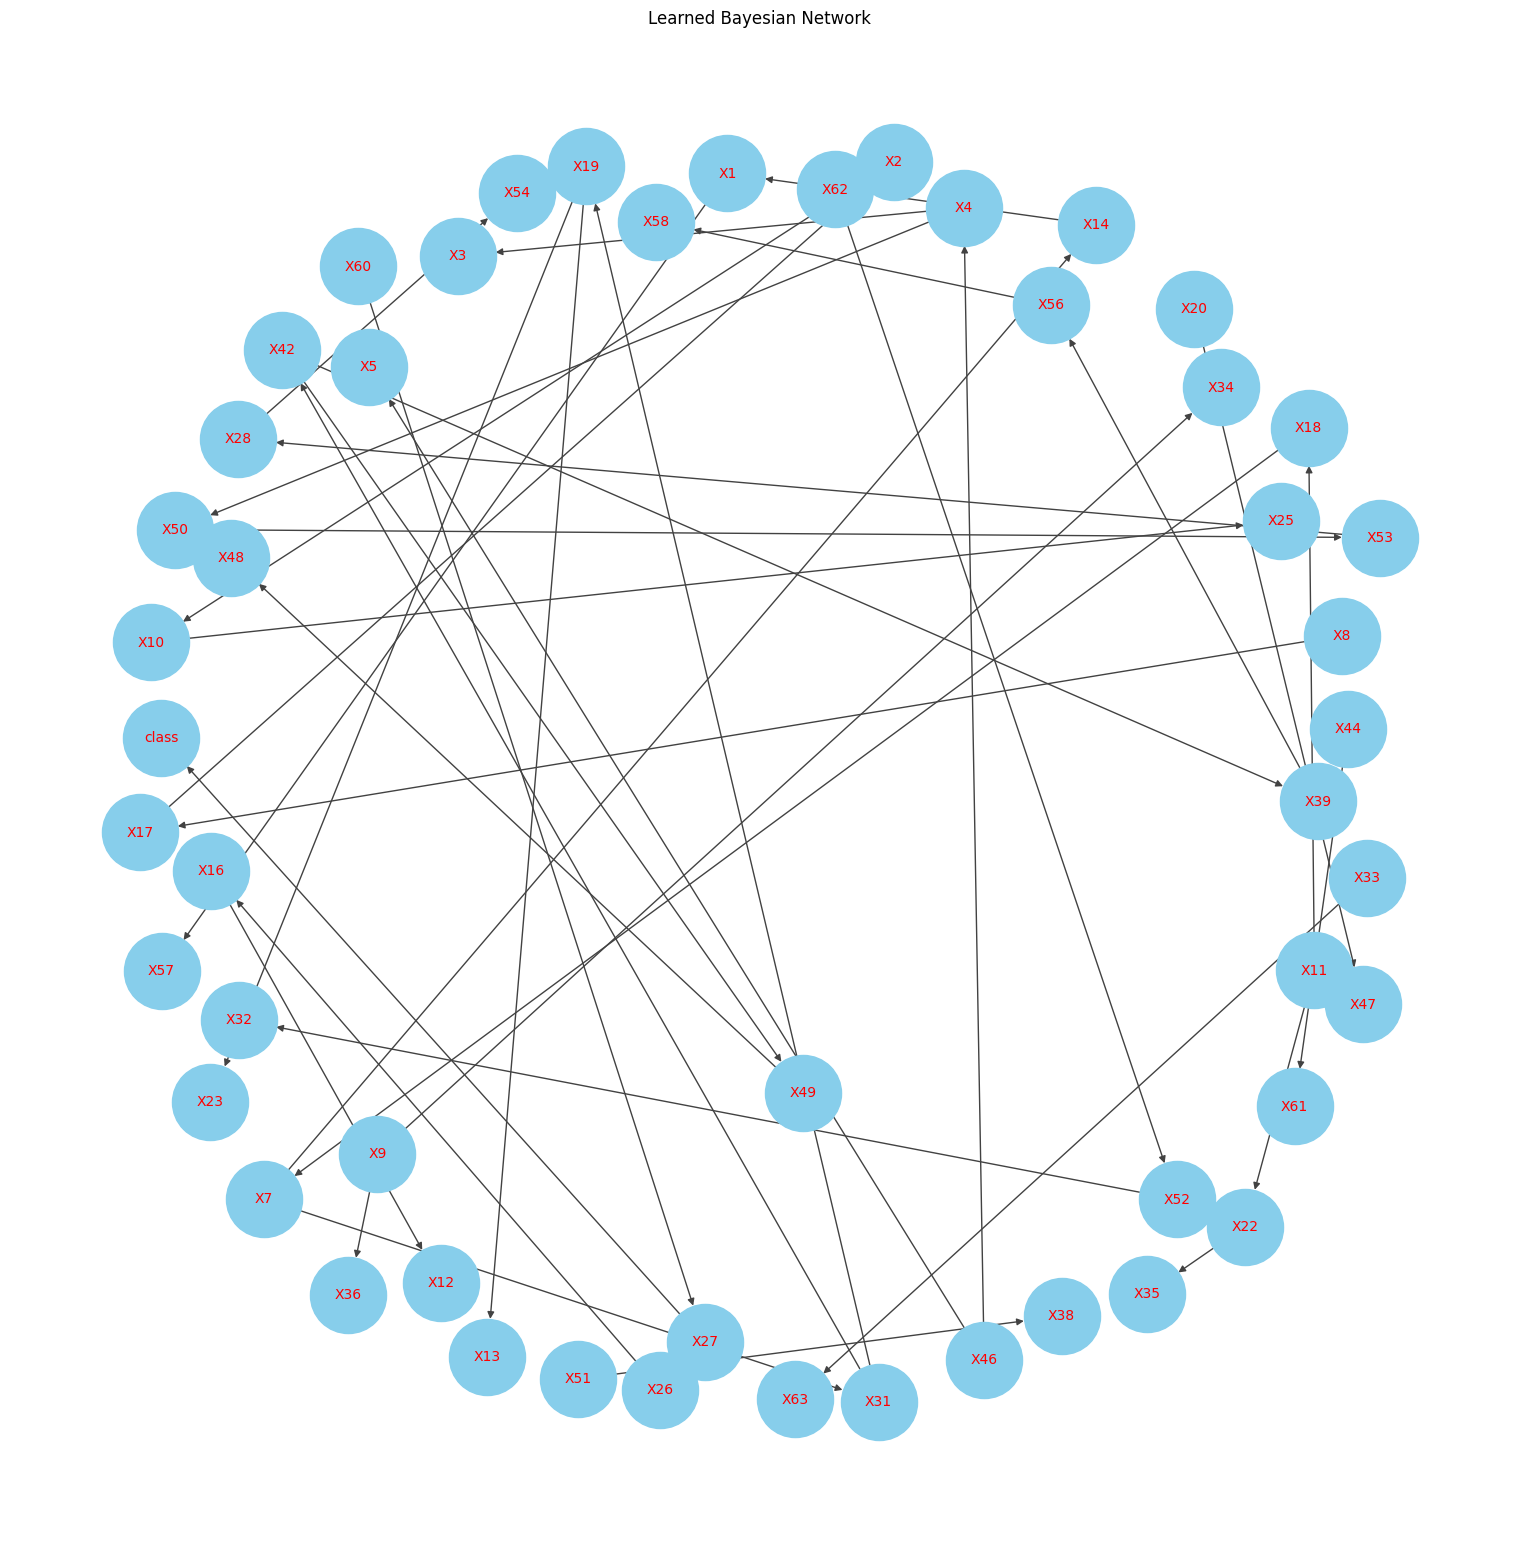

In [486]:
nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(15, 15))
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color = 'skyblue', edge_color='#424242',font_size=10,font_color='red')
plt.title('Learned Bayesian Network')
plt.show()

Parameter Estimation

In [487]:
equivalent_sample_size_dict = {}

for node in model.nodes():
    if node == 'class':
        equivalent_sample_size_dict[node] = 30
    else:
        equivalent_sample_size_dict[node] = 30


estimator = BayesianEstimator(model, training_data)
parameters = estimator.get_parameters(prior_type='dirichlet', pseudo_counts  = 1 )
#parameters = estimator.get_parameters(prior_type='BDeu', equivalent_sample_size = equivalent_sample_size_dict )

cpd_C = estimator.estimate_cpd('class', prior_type="dirichlet", pseudo_counts= 1)
#parameters = estimator.get_parameters(prior_type='dirichlet', pseudo_counts = 1, n_jobs = 6)


for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])
    
print(cpd_C)

+----------+--------------------+-----+-----------+--------------------+
| X27      | X27(0.0)           | ... | X27(13.0) | X27(19.0)          |
+----------+--------------------+-----+-----------+--------------------+
| class(0) | 0.6666666666666666 | ... | 0.75      | 0.6666666666666666 |
+----------+--------------------+-----+-----------+--------------------+
| class(1) | 0.3333333333333333 | ... | 0.25      | 0.3333333333333333 |
+----------+--------------------+-----+-----------+--------------------+


Inference

In [488]:
for i in range(len(testing_evidence_list)):
    for attribute in list(testing_evidence_list[i].keys()):
        if attribute not in model.nodes():
            del testing_evidence_list[i][attribute]
            

inference = VariableElimination(model)
elimination_order = WeightedMinFill(model).get_elimination_order(model.nodes())
elimination_order.remove('class')



y_pred = []
y_true = []

for i in range(len(testing_evidence_list)):
    bunkrupt_or_not = inference.map_query(['class'], evidence=testing_evidence_list[i], show_progress=False)
    y_pred.append(bunkrupt_or_not['class'])
    y_true.append(testing_targets.iloc[i])
    #print("True: " + str(testing_targets.iloc[i]) + "   Pred: " + str(bunkrupt_or_not['class']))

Finding Elimination Order: : 100%|██████████| 51/51 [00:00<00:00, 13303.66it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Testing Model

In [ ]:
data_testing_corr_score = model.simulate(int(1e4))
correlation_score = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
log_likelihood_score = log_likelihood_score(model, data_testing_corr_score)
structure_score = structure_score(model, data_testing_corr_score, scoring_method="bic")
print("correlation score: " + str(correlation_score))
print("Log likelihood score: " + str(log_likelihood_score))
print("Structure score: "+ str(structure_score))

accuracy_score = accuracy_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
precisionScore = precision_score(y_true, y_pred)
recallScore = recall_score(y_true, y_pred)
roc_auc_score =  roc_auc_score(y_true, y_pred)
balanced_accuracy_score = balanced_accuracy_score(y_true, y_pred,adjusted=True)

f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_score_macro = precision_score(y_true, y_pred, average='macro')
recall_score_macro = recall_score(y_true, y_pred, average='macro')

f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

print("accuracy score: "+str(accuracy_score))
print("f1_score: "+str(f1score))
print("precision score: "+str(precisionScore))
print("recall score: "+str(recallScore))
print("roc auc score: "+str(roc_auc_score))
print("balanced_accuracy_score: " + str(balanced_accuracy_score))
print("\n\n")
print("Macro scores:\n")
print("recall_score_macro: "+str(recall_score_macro))
print("f1_score_macro: "+str(f1_score_macro))
print("precision_score_macro: "+str(precision_score_macro))
print("\n")
print("Weighted Scores:\n")
print("recall_score_weighted: "+str(recall_score_weighted))
print("f1_score_weighted: "+str(f1_score_weighted))
print("precision_score_weighted: "+str(precision_score_weighted))

Generating for node: X47:   0%|          | 0/64 [00:00<?, ?it/s]

Generating for node: X58: 100%|██████████| 64/64 [00:00<00:00, 142.59it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


correlation score: 0.4886561954624782
Log likelihood score: -978665.83134806
Structure score: -1001265.3352324301
accuracy score: 0.9673024523160763
f1_score: 0.0
precision score: 0.0
recall score: 0.0
roc auc score: 0.5
balanced_accuracy_score: 0.0



Macro scores:

recall_score_macro: 0.5
f1_score_macro: 0.4916897506925208
precision_score_macro: 0.48365122615803813


Weighted Scores:

recall_score_weighted: 0.9673024523160763
f1_score_weighted: 0.951225403247111
precision_score_weighted: 0.935674034256695


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Export Model

In [ ]:
#writer = BIFWriter(model)
#writer.write_bif('model.bif')